# Preprocessing

Load DBS all channal data   
Bipolar referencing   
High pass filter    

setting for low and high pass
https://neurodsp-tools.github.io/neurodsp/generated/neurodsp.filt.filter_signal.html 

1. low pass filter at 250 hz
2. high pass filter at 0.1 hz
3. notch filter for line noise
4. downsample to 1000 hz (3 times above the LPF, read the reference https://en.wikipedia.org/wiki/Anti-aliasing_filter)
5. bipolar re-reference from shafts to rings
6. plot power spectrum 

In [30]:
import scipy
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Analysis
from scipy import signal
from neurodsp.spectral import compute_spectrum
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series

In [2]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/fuq01' 
# Specify subject names 
subj_ids = ['701','702','705','814','815']

mat_dict = {f'{x}': [] for x in subj_ids}
elec_dict = {f'{x}': [] for x in subj_ids}

In [3]:
elec_channal = ['CRAW_01', 'CRAW_02', 'CRAW_03', 'CRAW_04', 'CRAW_05', 'CMacro_RAW_01', 'CMacro_RAW_02', 'CMacro_RAW_03']
elec_dic = {'ring 0': 'CLFP1', 'seg 1A': 'CLFP2', 'seg 1B': 'CLFP3', 'seg 1C': 'CLFP4', 'seg 2A': 'CLFP5', 'seg 2B': 'CMacro LFP1', 'seg 2C': 'CMacro LFP1', 'ring 3': 'CMacro LFP3'}

In [4]:
def load_mat(dir_files):
    data_all = []
    for m in dir_files:
        file = scipy.io.loadmat(m)
        data_all.append(file)
    return data_all

In [5]:
sub_dir = f'{base_dir}/Documents/GitHub/leap-analysis/LFP/data/702'
mat_file = load_mat(glob.glob(f'{sub_dir}/*.mat'))
example_data = mat_file[0]

In [6]:
example_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Apr 10 12:09:51 2023',
 '__version__': '1.0',
 '__globals__': [],
 'CLFP_01': array([[-46, -44, -43, ..., -28, -30, -30]], dtype=int16),
 'CLFP_01_KHz': array([[1.375]]),
 'CLFP_01_KHz_Orig': array([[1.375]]),
 'CLFP_01_BitResolution': array([[38.14697266]]),
 'CLFP_01_Gain': array([[20]], dtype=uint8),
 'CLFP_01_TimeBegin': array([[11791.83272727]]),
 'CLFP_01_TimeEnd': array([[11854.328]]),
 'CLFP_02': array([[-45, -43, -42, ...,  26,  25,  25]], dtype=int16),
 'CLFP_02_KHz': array([[1.375]]),
 'CLFP_02_KHz_Orig': array([[1.375]]),
 'CLFP_02_BitResolution': array([[38.14697266]]),
 'CLFP_02_Gain': array([[20]], dtype=uint8),
 'CLFP_02_TimeBegin': array([[11791.83272727]]),
 'CLFP_02_TimeEnd': array([[11854.328]]),
 'CLFP_03': array([[241, 242, 243, ...,  92,  91,  91]], dtype=int16),
 'CLFP_03_KHz': array([[1.375]]),
 'CLFP_03_KHz_Orig': array([[1.375]]),
 'CLFP_03_BitResolution': array([[38.14697266]]),
 'CLFP_

In [7]:
example_data['CRAW_01'].shape

(1, 2749761)

In [41]:
fs = example_data['CRAW_01_KHz'].flatten()*1000
fs = fs[0].astype(np.float32)
sig = example_data['CRAW_01'].flatten()

In [ ]:
# raw filtering
low_pass = filter_signal(sig, fs=fs, pass_type='lowpass', filter_type='fir', f_range=250)
high_pass = filter_signal(low_pass, fs=fs, pass_type='highpass', filter_type='fir', f_range=0.1)
# notch = filter_signal(high_pass, fs=fs, pass_type='bandstop', filter_type='fir', f_range=[59, 61])
notch = filter_signal(high_pass, fs=fs, pass_type='bandstop', filter_type='fir', f_range=[58, 62])

In [43]:
# low-pass filtering 
sig_filt = filter_signal(sig, fs, 'lowpass', (None, 250))
sig_filt

array([nan, nan, nan, ..., nan, nan, nan])

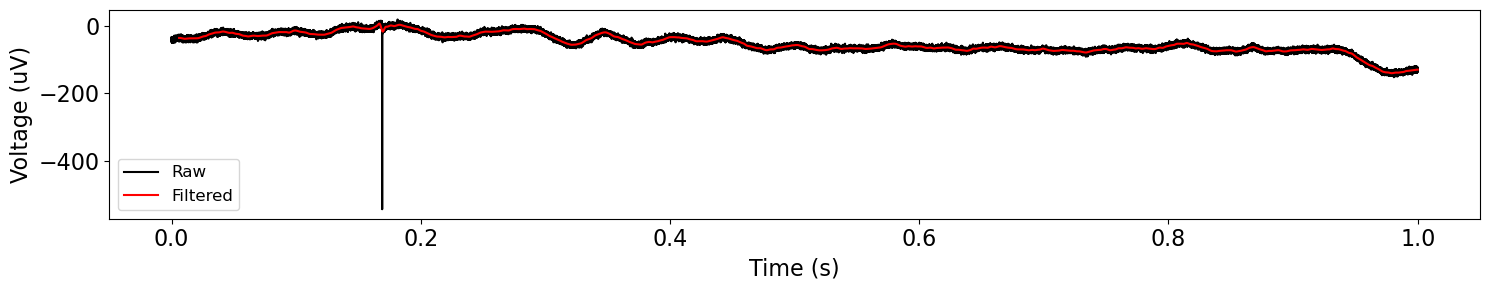

In [46]:
times = create_times(1, fs)
p_raw = sig[0:44000]
p_filt = sig_filt[0:44000]
plot_time_series(times, [p_raw, p_filt], ['Raw', 'Filtered'])

In [47]:
sig_filt_high = filter_signal(sig, fs, 'highpass', (1, None))
sig_filt_high

array([nan, nan, nan, ..., nan, nan, nan])

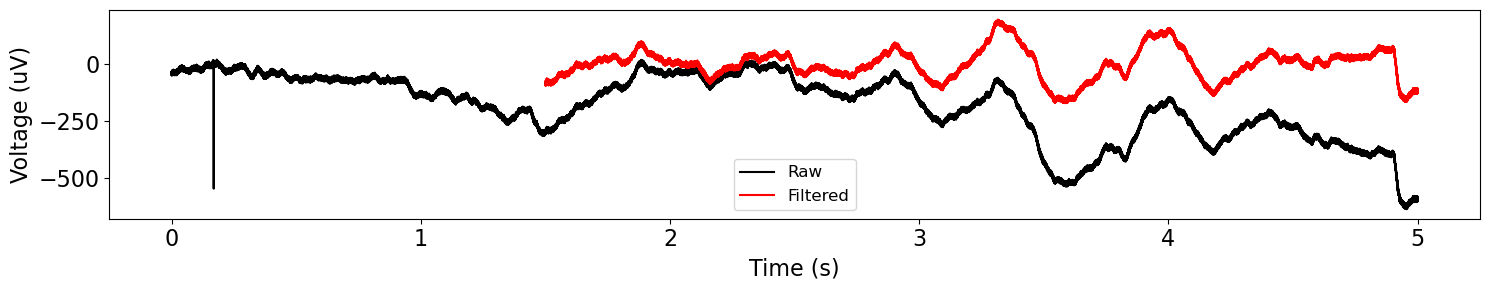

In [49]:
# Generate a times vector, for plotting
times = create_times(5, fs)
p_raw = sig[0:44000*5]
p_filt = sig_filt_high[0:44000*5]
plot_time_series(times, [p_raw, p_filt], ['Raw', 'Filtered'])

In [53]:
# notch filter 
sig_filt_notch = filter_signal(sig, fs, 'bandstop', (58, 62), n_seconds=0.5)

c:\Users\fuq01\Anaconda3\envs\LFPAnalysis\Lib\site-packages\neurodsp\filt\checks.py:153: UserWarning: The filter attenuation never goes below -20 dB. Increase filter length.
  warn('The filter attenuation never goes below {} dB. '\


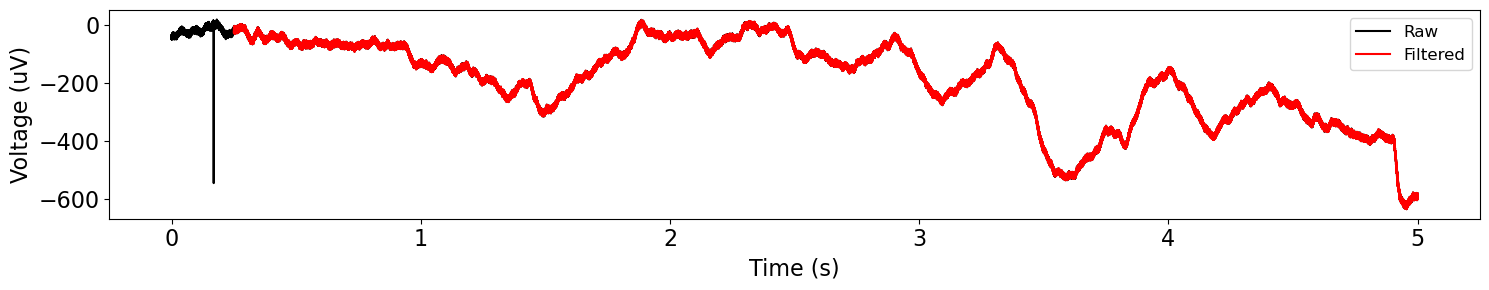

In [54]:
# Generate a times vector, for plotting
times = create_times(5, fs)
p_raw = sig[0:44000*5]
p_filt = sig_filt_notch[0:44000*5]
plot_time_series(times, [p_raw, p_filt], ['Raw', 'Filtered'])

In [56]:
# apply all three filters
sig_filt_all = filter_signal(sig, fs, 'bandpass', (1, 250))
sig_filt_all = filter_signal(sig_filt_all, fs, 'bandstop', (58, 62), n_seconds=0.5)

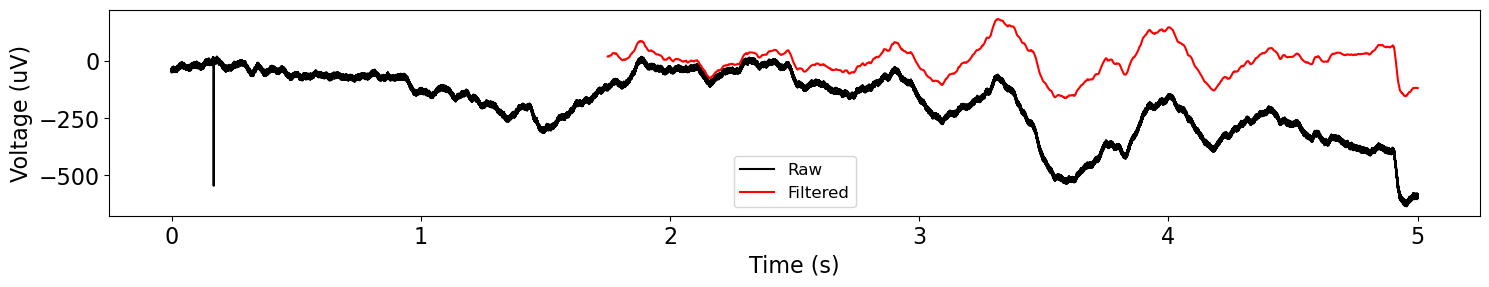

In [57]:
times = create_times(5, fs)
p_raw = sig[0:44000*5]
p_filt = sig_filt_all[0:44000*5]
plot_time_series(times, [p_raw, p_filt], ['Raw', 'Filtered'])

In [59]:
print(sig_filt_all[0:44000])

[nan nan nan ... nan nan nan]


In [14]:
low_pass, high_pass, notch

(array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

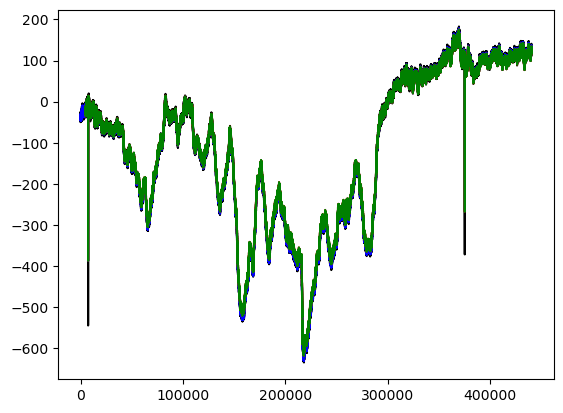

In [15]:
plt.plot(sig[:440000], color='black')
plt.plot(low_pass[:440000], color='blue')
plt.plot(high_pass[:440000], color='red')
plt.plot(notch[:440000], color='green')

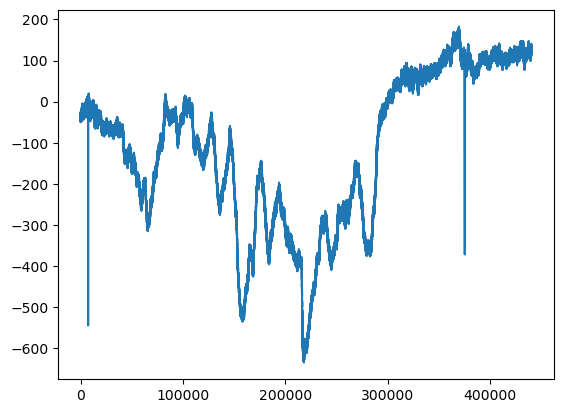

In [16]:
#This is ten seconds of raw dat afrom the first ring electrode
plt.plot(example_data['CRAW_01'][0, :440000])

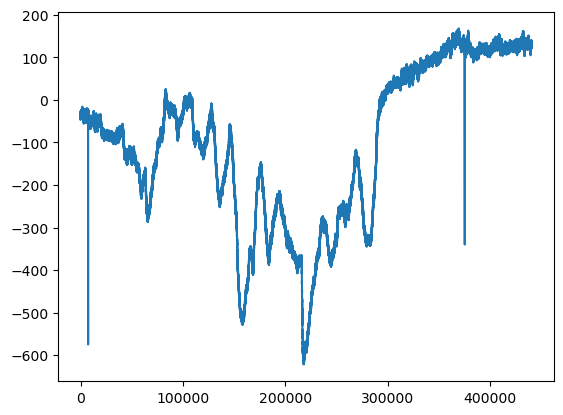

In [17]:
plt.plot(example_data['CRAW_02'][0, :440000])

In [18]:
def downsample(lfp, hz, downsample_factor):
    '''
    Downsample signal by a factor of downsample_factor
    '''
    signal_ds = signal.decimate(lfp.flatten(), downsample_factor)
    signal_hz = hz/downsample_factor
    if np.mod(hz, downsample_factor) != 0:
        raise ValueError('Sampling rate must be an integer after downsampling. Check your factor')
    return signal_ds, signal_hz

In [94]:
notch

array([nan, nan, nan, ..., nan, nan, nan])

In [19]:
ds_sig, ds_hz = downsample(notch, fs, 44)
ds_sig

array([nan, nan, nan, ..., nan, nan, nan])

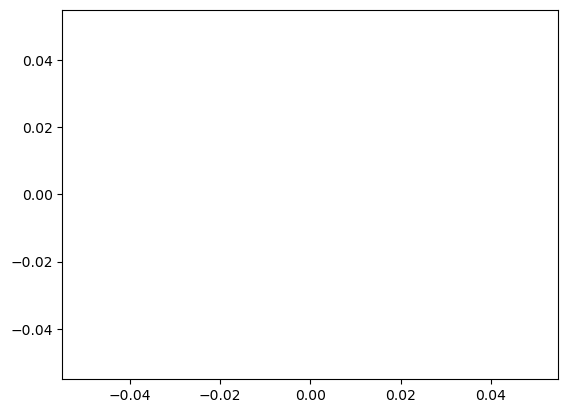

In [20]:
plt.plot(ds_sig)

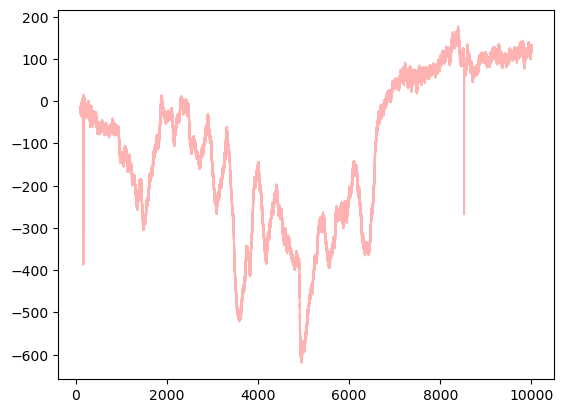

In [97]:
ts1 = np.arange(10000)
ts2 = np.linspace(0, 10000, 440000)
plt.plot(ts1, ds_sig[:10000])
plt.plot(ts2, notch[:440000], 'r', alpha = 0.3)

In [12]:
ref1 = example_data['CRAW_01'] - example_data['CRAW_02']
ref2 = example_data['CRAW_01'] - example_data['CRAW_03']
ref3 = example_data['CRAW_01'] - example_data['CRAW_04']

ref4 = example_data['CMacro_RAW_03'] - example_data['CRAW_05']
ref5 = example_data['CMacro_RAW_03'] - example_data['CMacro_RAW_01']
ref6 = example_data['CMacro_RAW_03'] - example_data['CMacro_RAW_02']
 

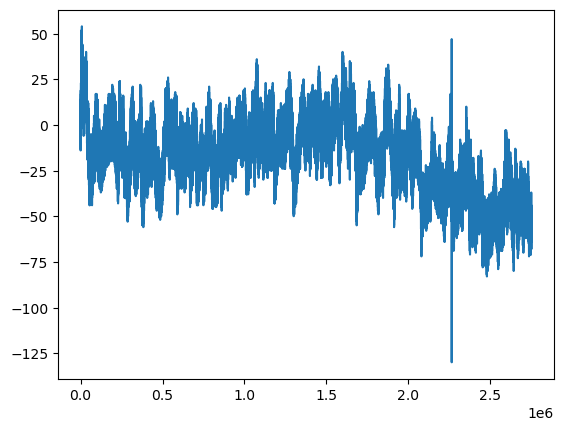

In [18]:
plt.plot(ref1[0, :4400000])

In [20]:
orginal_hz = example_data['CRAW_01_KHz'].flatten()*1000
ref1_ds, ref1_hz = downsample(ref1, orginal_hz, 44)

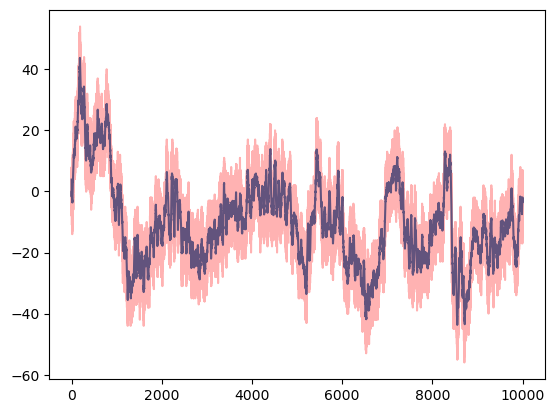

In [29]:
# checking original vs downsampled and plot on the same axis

ts1 = np.arange(10000)
ts2 = np.linspace(0, 10000, 440000) # generate x axis for original data 
plt.plot(ts1, ref1_ds[:10000]) # downsampled
plt.plot(ts2, ref1[0, :440000], 'r', alpha = 0.3) # original

# ok downsampling looks good 

In [ ]:
# line noise filter
orginal_hz = example_data['CRAW_01_KHz'].flatten()*1000
raw = example_data['CRAW_02'].flatten()
ref1 = ref1.flatten()

f_range = (58, 62)
sig_filt = filter_signal(ref1, orginal_hz, 'bandpass', f_range, n_seconds=1, plot_properties=True)

In [ ]:
from neurodsp.utils import create_times
second = len(ref1)/orginal_hz
times = create_times(second[0], orginal_hz)
plot_time_series(times, [ref1, sig_filt], ['Original','Filtered'])

In [ ]:
sig_filt

In [ ]:
orginal_hz = example_data['CRAW_01_KHz'].flatten()*1000
ref1_ds, ref1_hz = downsample(ref1, orginal_hz, 44)

In [ ]:
ref1_ds

In [ ]:
len(ref1_ds.flatten()), len(ref1.flatten())

In [35]:
orginal_hz = example_data['CRAW_01_KHz'].flatten()*1000

In [38]:
orginal_hz

array([44000], dtype=uint16)

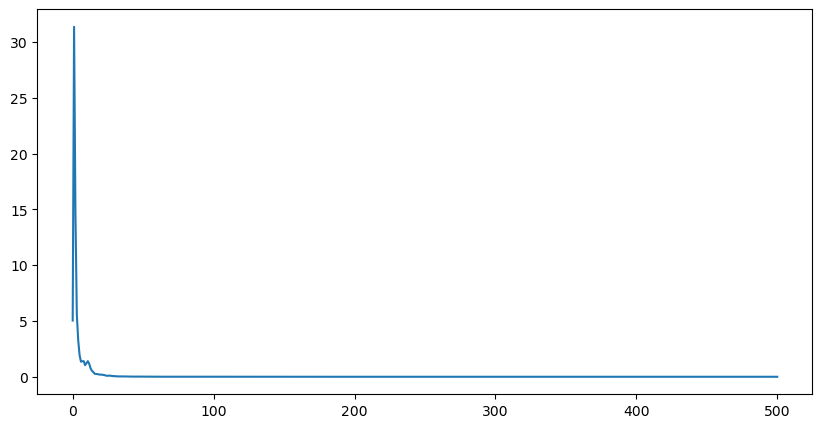

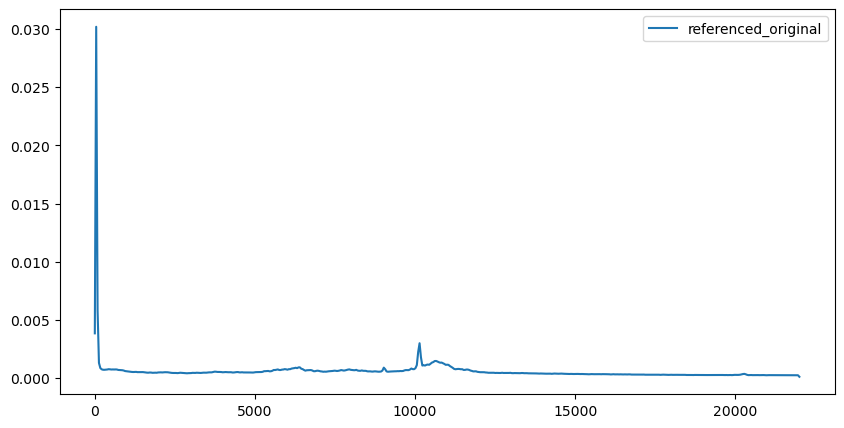

In [42]:
freq_mean1, psd_mean1 = compute_spectrum(ref1_ds, ref1_hz, method='welch', avg_type='mean', nperseg=1024)
freq_mean2, psd_mean2 = compute_spectrum(ref1.flatten(), orginal_hz, method='welch', avg_type='mean', nperseg=1024)

new_freq1 = freq_mean1[freq_mean1<120]
new_psd1 = psd_mean1[freq_mean1<120]

new_freq2 = freq_mean2[freq_mean2<120]
new_psd2 = psd_mean2[freq_mean2<120]

plt.figure(figsize=(10, 5))
plt.plot(freq_mean1, psd_mean1, label='referenced_downsampled')
plt.figure(figsize=(10, 5))
plt.plot(freq_mean2, psd_mean2, label='referenced_original')
plt.legend()

In [ ]:
from neurodsp.plts.spectral import plot_power_spectra
plot_power_spectra([new_freq1, new_freq2], [new_psd1, new_psd2],['referenced_downsampled', 'referenced_original'], log_freqs=True)